In [2]:
STOCK_SIZE = 100

In [3]:
def read_instance(path):
    with open(path, 'r') as f:
        orders = [int(x) for x in f.readline().split()]
        return orders

# Simulated annealing

In [4]:
import math
from matplotlib import pyplot as plt
import random
from copy import deepcopy

In [5]:
def initialize(orders: list[int], shuffle: bool = False) -> list[int]:
    solution = deepcopy(orders)
    if shuffle:
        random.shuffle(solution)
    return solution

In [6]:
def calc_solution_value(orders: list[int]) -> tuple[int, int]:
    
    leftovers = []
    num_stocks = 0
    
    for order in orders:
        
        order_cut = False
        
        for j, leftover in enumerate(leftovers):
            if order <= leftover:
                leftovers[j] -= order
                order_cut = True
                break
        
        if not order_cut:
            num_stocks += 1
            leftovers.append(STOCK_SIZE - order)
        
    leftovers.sort(reverse = True)
        
    result = 0    
    for i, leftover in enumerate(leftovers):
        if leftover == 0:
            break
        result += (i+1) * leftover
        
    return result, num_stocks

In [7]:
def swap(orders: list[int]): 
    idx1 = random.randrange(len(orders))
    idx2 = random.randrange(len(orders))
    while orders[idx1] == orders[idx2]:
        idx2 = random.randrange(len(orders))
        
    tmp = orders[idx1]
    orders[idx1] = orders[idx2]
    orders[idx2] = tmp
    
def insert(orders: list[int]):
    pos1 = random.randrange(len(orders))
    pos2 = random.randrange(len(orders))
    
    while pos2 == pos1:
        pos2 = random.randrange(len(orders))
        
    element = orders.pop(pos1)
    orders.insert(pos2, element)
    
def inverse(orders: list[int]):
    pos1 = random.randrange(len(orders))
    pos2 = random.randrange(len(orders))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(orders))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
        
    orders[pos1:pos2 + 1] = orders[pos1:pos2 + 1][::-1]
    
def shuffle(orders):
    pos1 = random.randrange(len(orders))
    pos2 = random.randrange(len(orders))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(orders))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
                
    segment = orders[pos1:pos2+1]
    random.shuffle(segment)
    
    orders[pos1:pos2+1] = segment

In [8]:
def calc_temperature_1(current_temp: float, alpha: float) -> float:
    return current_temp / (1 + alpha * current_temp)

def calc_temperature_2(current_temp: float, alpha: float) -> float:
    return current_temp * alpha

def calc_alpha(initial_temp: float, min_temp: float, num_iters: int) -> float:
    return (initial_temp - min_temp) / (num_iters * initial_temp * min_temp)

In [9]:
from typing import Callable

In [10]:
def simulated_annealing(orders: list[int],
                        initial_temp: float = 100,
                        min_temp: float = 1,
                        alpha: float = None,
                        max_iters: int = 5000,
                        make_small_change: Callable[[list[int]], None] = swap,
                        calc_temperature: Callable[[float, float], float] = calc_temperature_1,
                        plot: bool = False,
                        max_accepted_solutions: int = 2,
                        sum_best_values: list[int] = None,
                        sum_num_stocks: list[int] = None,
                        sum_value_perc_improvement: list[float] = None,
                        sum_num_stocks_perc_improvement: list[float] = None
                        ) -> tuple[list[int], int, int]:
    if alpha is None:
        alpha = calc_alpha(initial_temp, min_temp, max_iters)
    
    num_orders = len(orders)
    solution = initialize(orders)
    temperature = initial_temp
    
    value, stocks_used = calc_solution_value(solution)
    best_solution = deepcopy(solution)
    best_value = value
    best_stocks_used = stocks_used

    PLT_VALUES = []
    PLT_STOCKS_USED = []
    ITERS = 0
        
    while temperature > min_temp and ITERS < max_iters:
        accepted_solutions = 0
        new_solution = deepcopy(solution)
        make_small_change(new_solution)
        new_value, new_stocks_used = calc_solution_value(new_solution)
        
        diff = new_value - value
        if diff <= 0:
            solution = deepcopy(new_solution)
            value = new_value
            stocks_used = new_stocks_used
            
            if new_value < best_value:
                best_value = new_value
                best_solution = deepcopy(new_solution)
                best_stocks_used = new_stocks_used
                
            accepted_solutions += 1    
            
        elif random.random() < (math.e)**((-diff) / temperature):
            value = new_value
            solution = deepcopy(new_solution)
            stocks_used = new_stocks_used
            accepted_solutions += 1
        
        if diff > 0 or accepted_solutions >= max_accepted_solutions:
            temperature = calc_temperature(temperature, alpha)
                    
        PLT_VALUES.append(value)
        PLT_STOCKS_USED.append(stocks_used)
        ITERS += 1
          
# -------------------------------------------------------------------------------------

    if plot:      
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
        
    if sum_best_values is not None:
        if len(PLT_VALUES) < len(sum_best_values):
            PLT_VALUES.extend([PLT_VALUES[-1]] * (len(sum_best_values) - len(PLT_VALUES)))
        
        for i in range(len(sum_best_values)):
            sum_best_values[i] = sum_best_values[i] + PLT_VALUES[i]
        
    if sum_num_stocks is not None:
        if len(PLT_STOCKS_USED) < len(sum_num_stocks):
            PLT_STOCKS_USED.extend([PLT_STOCKS_USED[-1]] * (len(sum_num_stocks) - len(PLT_STOCKS_USED)))
        for i in range(len(sum_num_stocks)):
            sum_num_stocks[i] = sum_num_stocks[i] + PLT_STOCKS_USED[i]
            
    if sum_value_perc_improvement is not None:
        if len(PLT_VALUES) < len(sum_value_perc_improvement):
            PLT_VALUES.extend([PLT_VALUES[-1]] * (len(sum_value_perc_improvement) - len(PLT_VALUES)))
        
        initial_val = PLT_VALUES[0]
        perc_improvement = [((initial_val - val) / initial_val * 100) for val in PLT_VALUES]
        
        for i in range(len(sum_value_perc_improvement)):
            sum_value_perc_improvement[i] = sum_value_perc_improvement[i] + perc_improvement[i]
            
    if sum_num_stocks_perc_improvement is not None:
        if len(PLT_STOCKS_USED) < len(sum_num_stocks_perc_improvement):
            PLT_STOCKS_USED.extend([PLT_STOCKS_USED[-1]] * (len(sum_num_stocks_perc_improvement) - len(PLT_STOCKS_USED)))
    
        initial_num_stocks = PLT_STOCKS_USED[0]
        perc_improvement = [((initial_num_stocks - num_stocks) / initial_num_stocks * 100) for num_stocks in PLT_STOCKS_USED]
        
        for i in range(len(sum_num_stocks_perc_improvement)):
            sum_num_stocks_perc_improvement[i] = sum_num_stocks_perc_improvement[i] + perc_improvement[i]
        
    return best_solution, best_value, best_stocks_used

In [18]:
orders = read_instance('test_instances/test_instance_20.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

4478851 751


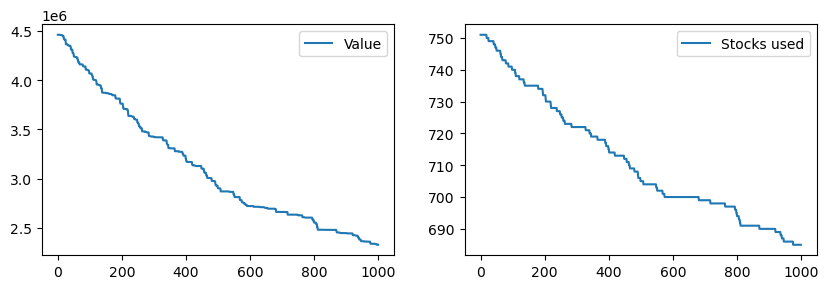

2326936 685


In [19]:
solution, value, stocks_used = simulated_annealing(orders, initial_temp=100, min_temp=5, max_iters=1000, plot=True)
print(value, stocks_used)

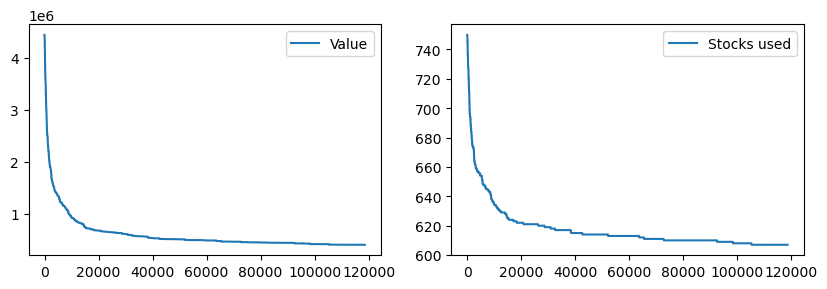

407144 607


In [68]:
solution, value, stocks_used = simulated_annealing(orders, plot=True, max_iters=1000000, min_temp=1)
print(value, stocks_used)

### Parameter tuning

In [10]:
def sa_test_all_instances(results_df,
                          combination_num,
                          initial_temp,
                          min_temp,
                          max_accepted_solutions,
                          calc_temperature,
                          make_small_change
                         ):

    for i in range(21):
        orders = read_instance(f'test_instances/test_instance_{i}.csp')
        _, value, stocks_used = simulated_annealing(orders,
                                                    initial_temp=initial_temp,
                                                    min_temp=min_temp,
                                                    max_accepted_solutions=max_accepted_solutions,
                                                    calc_temperature=calc_temperature,
                                                    make_small_change=make_small_change
                                                   )
        
        results_df.loc[combination_num, 'make_small_change function'] = make_small_change.__name__
        results_df.loc[combination_num, [f'instance {i} value', f'instance {i} num stocks']] = [value, stocks_used]

#### Grid search

In [36]:
import pandas as pd

In [33]:
initial_temps = [50, 100, 300, 500, 750, 1000]
min_temps = [1, 5, 10, 15]
max_accepted = [1, 2, 3, 4, 5, float('inf')]

grid_search_df = pd.DataFrame(columns=['initial_temp', 'min_temp', 'max_acc_solutions'])
combination_num = 0

for initial_temp in initial_temps:
    for min_temp in min_temps:
        for max_acc in max_accepted:
            print(f'Combination {combination_num+1}/144   ', end='\r')
            sa_test_all_instances(results_df=grid_search_df,
                                  combination_num=combination_num,
                                  initial_temp=initial_temp,
                                  min_temp=min_temp,
                                  max_accepted_solutions=max_acc
                                 )
            combination_num += 1

In [121]:
grid_search_df

,initial_temp,min_temp,max_acc_solutions,instance 0 value,instance 0 num stocks,instance 1 value,instance 1 num stocks,instance 2 value,instance 2 num stocks,instance 3 value,...,instance 16 value,instance 16 num stocks,instance 17 value,instance 17 num stocks,instance 18 value,instance 18 num stocks,instance 19 value,instance 19 num stocks,instance 20 value,instance 20 num stocks
0,50,1,1,615.0,16.0,194.0,19.0,5300.0,48.0,1578.0,...,13326.0,164.0,2079439.0,594.0,354453.0,444.0,172021.0,371.0,1299335.0,650.0
1,50,1,2,615.0,16.0,173.0,19.0,4929.0,48.0,1645.0,...,15772.0,165.0,2130887.0,596.0,352454.0,444.0,173492.0,370.0,1226747.0,647.0
2,50,1,3,615.0,16.0,191.0,19.0,4904.0,48.0,1100.0,...,13588.0,164.0,2085605.0,595.0,367641.0,446.0,167431.0,371.0,1252708.0,649.0
3,50,1,4,615.0,16.0,151.0,19.0,4922.0,48.0,1318.0,...,12743.0,163.0,2062251.0,593.0,406605.0,449.0,140152.0,365.0,1256373.0,648.0
4,50,1,5,615.0,16.0,163.0,19.0,4874.0,48.0,717.0,...,11776.0,164.0,2134009.0,597.0,333198.0,444.0,153763.0,370.0,1228428.0,646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1000,15,2,624.0,16.0,308.0,19.0,5028.0,48.0,1648.0,...,14969.0,165.0,2041432.0,593.0,327292.0,442.0,153310.0,368.0,1194112.0,646.0
140,1000,15,3,621.0,16.0,247.0,19.0,4943.0,48.0,1785.0,...,14020.0,164.0,2090267.0,595.0,360327.0,446.0,152487.0,368.0,1187273.0,645.0
141,1000,15,4,632.0,16.0,258.0,19.0,5085.0,48.0,1816.0,...,12909.0,163.0,2074141.0,594.0,325348.0,442.0,172685.0,371.0,1262247.0,648.0
142,1000,15,5,627.0,16.0,272.0,19.0,4998.0,48.0,1696.0,...,9830.0,162.0,2078235.0,594.0,295409.0,440.0,169759.0,370.0,1222228.0,646.0


In [123]:
grid_search_df.to_csv('sa_grid_search.csv')

Chosen initial temperature: 100 \
Chosen min temperature: 1 \
Chosen max accepted solutions: 2

#### Calc temperature function

In [42]:
calc_temp_functions = [calc_temperature_1, calc_temperature_2]

calc_temp_df = pd.DataFrame(columns=['calc_temp function'])
combination_num = 0

for calc_temperature in calc_temp_functions:
    for i in range(5):
        sa_test_all_instances(results_df=calc_temp_df,
                              combination_num=combination_num,
                              initial_temp=100,
                              min_temp=1,
                              max_accepted_solutions=2,
                              calc_temperature=calc_temperature,
                             )
        combination_num += 1

In [49]:
calc_temp_df = pd.read_csv('sa_calc_temp.csv', index_col=0)
calc_temp_df

,calc_temp function,alpha,instance 0 value,instance 0 num stocks,instance 1 value,instance 1 num stocks,instance 2 value,instance 2 num stocks,instance 3 value,instance 3 num stocks,...,instance 16 value,instance 16 num stocks,instance 17 value,instance 17 num stocks,instance 18 value,instance 18 num stocks,instance 19 value,instance 19 num stocks,instance 20 value,instance 20 num stocks
0,calc_temperature_1,NaN,615,16,156,19,4854,48,900,47,...,13425,164,2122369,596,370035,446,155064,367,1296440,650
1,calc_temperature_1,NaN,615,16,179,19,4869,48,937,47,...,16166,165,2080717,594,334082,443,172079,371,1249881,647
2,calc_temperature_1,NaN,615,16,238,19,4854,48,1650,48,...,14305,164,2057272,594,330690,443,171815,371,1249719,649
3,calc_temperature_1,NaN,615,16,162,19,4863,48,1280,48,...,13669,164,2097626,595,312767,440,175861,371,1319148,650
4,calc_temperature_1,NaN,615,16,163,19,4863,48,1072,47,...,13334,163,2134888,597,357936,446,155071,370,1162215,643
5,calc_temperature_2,NaN,4392,20,4778,24,27129,57,23398,58,...,176947,191,3162881,631,2890103,550,1484107,452,4478851,751
6,calc_temperature_2,NaN,4392,20,4778,24,27129,57,23398,58,...,174906,191,3152985,631,2884871,550,1491627,452,4478851,751
7,calc_temperature_2,NaN,4392,20,4778,24,26756,57,23398,58,...,165660,189,3162881,631,2890103,550,1491627,452,4442885,750
8,calc_temperature_2,NaN,4092,20,4600,24,24915,56,20507,57,...,176947,191,3146084,630,2857569,549,1424501,449,4418962,750
9,calc_temperature_2,NaN,3347,19,4778,24,27129,57,23398,58,...,171186,190,3158145,631,2853456,549,1491627,452,4454429,750


In [36]:
calc_temp_df.to_csv('sa_calc_temp.csv')

Chosen calc_temperature function: calc_temperature_1

#### Make small change function

In [41]:
make_sc_functions = [swap, insert, inverse, shuffle]

make_sc_df = pd.DataFrame(columns=['make_small_change function'])
combination_num = 0

for make_small_change in make_sc_functions:
    for i in range(5):
        print(f'Combination {combination_num+1}/20  ', end='\r')
        sa_test_all_instances(results_df=make_sc_df,
                              combination_num=combination_num,
                              initial_temp=100,
                              min_temp=1,
                              max_accepted_solutions=2,
                              calc_temperature=calc_temperature_1,
                              make_small_change=make_small_change
                             )
        combination_num += 1

In [47]:
make_sc_df

,make_small_change function,instance 0 value,instance 0 num stocks,instance 1 value,instance 1 num stocks,instance 2 value,instance 2 num stocks,instance 3 value,instance 3 num stocks,instance 4 value,...,instance 16 value,instance 16 num stocks,instance 17 value,instance 17 num stocks,instance 18 value,instance 18 num stocks,instance 19 value,instance 19 num stocks,instance 20 value,instance 20 num stocks
0,swap,615,16,155,19,4989,48,1595,48,148,...,10610,162,2090319,595,297294,439,165229,369,1232905,647
1,swap,615,16,180,19,4880,48,1629,48,168,...,13501,164,2072887,594,343263,445,152071,367,1228052,647
2,swap,615,16,147,19,4854,48,943,47,208,...,15838,165,2116302,596,329532,442,151694,369,1202816,645
3,swap,615,16,171,19,4883,48,1416,48,401,...,12222,164,2130557,597,349647,444,154514,367,1221618,645
4,swap,615,16,167,19,4879,48,1408,48,353,...,12772,164,2137846,597,321258,441,170974,371,1226316,650
5,insert,620,16,206,19,4879,48,1607,48,215,...,19691,166,2102406,595,475606,450,189970,372,1475781,655
6,insert,618,16,256,19,4864,48,838,47,223,...,19761,166,2185521,598,446400,450,184998,370,1430983,654
7,insert,617,16,235,19,4960,48,1160,47,304,...,15194,164,2168857,598,430775,448,199945,373,1399405,653
8,insert,615,16,226,19,5256,48,1678,48,232,...,17111,163,2130093,596,406046,446,196737,372,1419908,654
9,insert,617,16,244,19,4933,48,1774,48,275,...,16326,163,2112075,595,442805,449,196560,372,1464719,654


In [44]:
make_sc_df.to_csv('sa_make_sc.csv')

In [ ]:
orders = read_instance('test_instances/test_instance_20.csp')
_, value, num_stocks = simulated_annealing(orders, initial_temp=100, min_temp=1, plot=True, max_iters=100000)
print(value, num_stocks)

Chosen make_small_change function: swap

#### Number of iterations

Average value and num_stocks through iterations

In [24]:
def sa_test_avg_value(num_iters):
    num_instances = 21
    sum_best_values = [0 for i in range(num_iters)]
    sum_num_stocks = [0 for i in range(num_iters)]

    for i in range(num_instances):
        orders = read_instance(f'test_instances/test_instance_{i}.csp')
        print(f'Instance {i+1}/{num_instances}  ', end='\r')
        _, value, num_stocks = simulated_annealing(orders=orders,
                                                   initial_temp=100,
                                                   min_temp=1,
                                                   max_iters=num_iters,
                                                   max_accepted_solutions=1,
                                                   calc_temperature=calc_temperature_1,
                                                   make_small_change=swap,
                                                   sum_best_values=sum_best_values,
                                                   sum_num_stocks=sum_num_stocks
                                                  )

    avg_best_values = [x / num_instances for x in sum_best_values]
    avg_num_stocks = [x / num_instances for x in sum_num_stocks]

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_iters), avg_best_values, label='Value')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_iters), avg_num_stocks, label='Stocks used')
    plt.legend()
    plt.show()

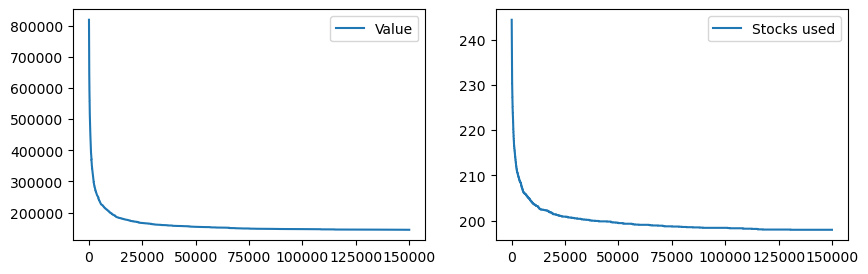

In [18]:
sa_test_avg_value(num_iters=150000)

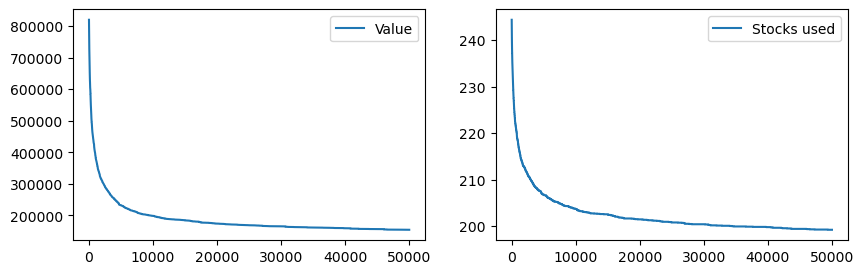

In [20]:
sa_test_avg_value(num_iters=50000)

Percentage improvement of value and num stocks through iterations

In [29]:
def sa_test_perc_improvement(num_iters):
    num_instances = 21
    sum_value_perc_improvement = [0 for _ in range(num_iters)]
    sum_num_stocks_perc_improvement = [0 for _ in range(num_iters)]
    
    for i in range(num_instances):
        orders = read_instance(f'test_instances/test_instance_{i}.csp')
        print(f'Instance {i+1}/{num_instances}  ', end='\r')
        _, value, num_stocks = simulated_annealing(orders,
                                                   max_iters=num_iters,
                                                   sum_value_perc_improvement=sum_value_perc_improvement,
                                                   sum_num_stocks_perc_improvement=sum_num_stocks_perc_improvement
                                                  )
    
    avg_value_perc_improvement = [x / num_instances for x in sum_value_perc_improvement]
    avg_num_stocks_perc_improvement = [x / num_instances for x in sum_num_stocks_perc_improvement]
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_iters), avg_value_perc_improvement, label='Value percenatage improvement')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_iters), avg_num_stocks_perc_improvement, label='Stocks used percentage improvement')
    plt.legend()
    plt.show()

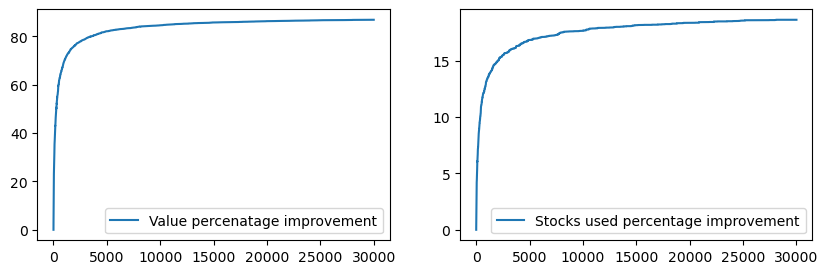

In [30]:
sa_test_perc_improvement(num_iters=30000)